# Get annotation match against NIST from mass spectrum

In [1]:
import os, sys
path_to_scr_folder=os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(path_to_scr_folder)
import plot
from read_chroma import read_only_chroma, read_chromato_and_chromato_cube
import pyms_nist_search
import pyms
import logging
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import projection
import mass_spec

def get_molecular_formulaNIST(compound_name):
    # Prepare the search query URL
    search_url = f'https://webbook.nist.gov/cgi/cbook.cgi?Name={compound_name}'

    # Make an HTTP request to the PubChem website
    response = requests.get(search_url)

    # Check if the request was successful (status code 200)
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text()
    res = re.search(r'Formula: (.*?)\nMolecular weight', text)
    if res:
        return res.group(1)
    else:
        return None

## load file

In [11]:
#need to open the file in files first otherwise fail to load
sample_name = "G0-1-041222.cdf"
chromato, time_rn, chromato_cube, sigma, mass_range=read_chromato_and_chromato_cube(f'/media/elie/Métabolomique/ELO_CDF/liquide-cdf-centroid/{sample_name}', mod_time=1.25, pre_process=False)

chromato read 10.524566650390625 s
--- 136.27232336997986 seconds --- to compute full spectra centroid
full spectra computed 137.61160516738892 s


In [9]:
mass_range

(39, 501)

In [5]:
import os
os.getcwd()

'/home/elie/Projects/Work/ahmed_repo/Python-2DGC-Alignment/notebooks'

In [13]:
chromato_cube.shape

(463, 2187, 150)

In [4]:
import docker

# Gracefully handle "container already exists" issue
def ensure_pyms_nist_container_clean():
    client = docker.from_env()
    try:
        container = client.containers.get("pyms-nist-server")
        if container.status == "exited":
            print("🧹 Removing existing stopped container: pyms-nist-server")
            container.remove()
        else:
            print("✅ pyms-nist-server is already running.")
    except docker.errors.NotFound:
        pass  # Container doesn't exist — no problem

# Call this before starting the Engine
ensure_pyms_nist_container_clean()


🧹 Removing existing stopped container: pyms-nist-server


In [5]:
#  run docker rm -f pyms-nist-server on command line if server is running

chromato_obj=(chromato, time_rn, mass_range)
hit_prob_min=15
match_factor_min=800
chromato, time_rn, spectra_obj = chromato_obj
if 'search' not in globals():
    search = pyms_nist_search.Engine(
                        "/media/elie/Métabolomique/NIST14/MSSEARCH/mainlib/",
                        pyms_nist_search.NISTMS_MAIN_LIB,
                        "/home/elie/Projects/Work/ahmed_repo/Python-2DGC-Alignment",
                        )
logger=logging.getLogger('pyms_nist_search')
logger.setLevel('ERROR')
logger=logging.getLogger('pyms')
logger.setLevel('ERROR')
try:
    (l1, l2, mv, iv, range_min, range_max) = spectra_obj
except:
    range_min, range_max=spectra_obj
mass_values = np.linspace(range_min, range_max, range_max - range_min + 1).astype(int)


Launching Docker...


## plot for manual check

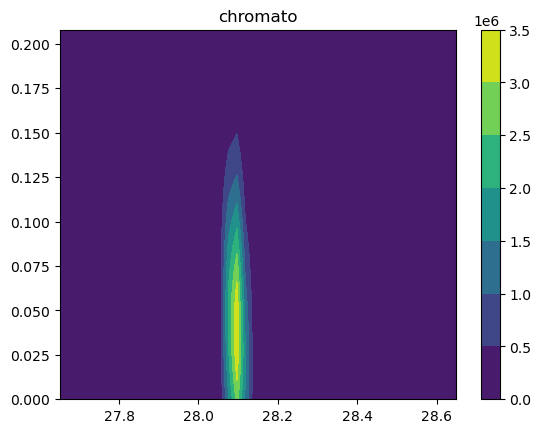

In [12]:
m=87
RT1=28.15*60
RT2=0.008

plot.visualizer((chromato_cube[m-39,:,:], time_rn), title="chromato", 
                log_chromato=False, rt1 = RT1/60, rt2 =RT2, rt1_window = 0.5, rt2_window = 0.2, mod_time=1.25)

In [42]:
u1 = projection.chromato_to_matrix(np.array([[RT1/60, RT2]]), time_rn, 1.25, chromato.shape)
coord = u1[0]
int_values = mass_spec.read_spectrum_from_chromato_cube(coord, chromato_cube=chromato_cube)
mass_spectrum = pyms.Spectrum.MassSpectrum(mass_values, int_values)
res = search.full_search_with_ref_data(mass_spectrum, n_hits=20)

# Initialisation d'un DataFrame vide
match = pd.DataFrame()

# Ajout des résultats
for entry in res:
    if entry and entry[0]:
        df = pd.DataFrame.from_dict(entry[0]).T
        if df.shape[0] > 1:
            row = df.iloc[[1]]
            row.columns = df.iloc[0]
            match = pd.concat([match, row])

# Si aucun match, on s'arrête là
if match.empty:
    print("❌ Aucun match trouvé.")
else:
    match['match_factor'] = pd.to_numeric(match['match_factor'], errors='coerce')
    match = match.dropna(subset=['match_factor'])

    match = match[(match['match_factor'] > match['match_factor'].max() - 100) & 
                  (match['match_factor'] > 650)]

    match['formula'] = ""

    if 'pyms_nist_searchname' in match.columns:
        for i in range(len(match)):
            formula = get_molecular_formulaNIST(match['pyms_nist_searchname'].iloc[i])
            match.at[i, 'formula'] = formula
    else:
        print("⚠️ La colonne 'pyms_nist_searchname' est absente des résultats.")

    display(match)

⚠️ La colonne 'pyms_nist_searchname' est absente des résultats.


,name,cas,match_factor,reverse_match_factor,spec_loc,hit_prob,formula
1,"Octanoic acid, methyl ester",111-11-5,815,862,53560689,59.65,
1,"Cyclopentaneundecanoic acid, methyl ester",25779-85-5,745,796,47709570,8.67,
1,Methyl 6-methyl heptanoate,2519-37-1,727,767,64498092,4.47,
1,"Octanoic acid, 2-methyl-",3004-93-1,718,781,50475588,3.24,


below useless for normal runnin

In [30]:
import os
print(os.path.exists("/home/elie/Projects/Work/ahmed_repo/ref_peak_pdf"))


True


In [ ]:
import importlib

<module 'plot' from '/home/elie/Projects/Work/ahmed_repo/Python-2DGC-Alignment/src/plot.py'>

Below automated plotting to PDF

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

# --- CONFIGURATION ---

output_dir = "/home/elie/Projects/Work/ahmed_repo/ref_peak_pdf"
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/{sample_name}_ref_peaks.pdf"

# Load full reference peak file (Etalons + FAMEs)
ref_peaks = pd.read_csv("/home/elie/Projects/Work/ahmed_repo/peak_coordinates.csv")

# Create PDF
with PdfPages(output_path) as pdf:
    for _, row in ref_peaks.iterrows():
        m = int(row['mass'])
        RT1 = float(row['RT1']) * 60  # convert to seconds
        RT2 = float(row['RT2'])
        name = row['Mol']

        m_index = m - 39  # adjust mass index
        title = f"{name} | Mass: {m} | RT1: {RT1/60:.2f} min | RT2: {RT2:.3f} s"

        print(f"📌 Plotting: {title}")

        # Plot and save to PDF
        plot.visualizer(
            (chromato_cube[m_index, :, :], time_rn),
            title=title,
            log_chromato=False,
            rt1=RT1 / 60,
            rt2=RT2,
            rt1_window=0.5,
            rt2_window=0.2,
            mod_time=1.25,
            show=False  # Suppress display in notebook
        )

        pdf.savefig(plt.gcf())
        plt.close(plt.gcf())

print(f"✅ PDF saved to:\n{output_path}")


📌 Plotting: Alanine-d4 | Mass: 120 | RT1: 12.37 min | RT2: 0.266 s
📌 Plotting: Valine-d8 | Mass: 152 | RT1: 15.46 min | RT2: 0.266 s
📌 Plotting: Nicotinic acid-d4 | Mass: 184 | RT1: 17.54 min | RT2: 0.907 s
📌 Plotting: Salycilic acid-d4 | Mass: 271 | RT1: 23.34 min | RT2: 0.341 s
📌 Plotting: Glutamic acid-d5 | Mass: 251 | RT1: 26.08 min | RT2: 0.666 s
📌 Plotting: Glucose-6C13 | Mass: 207 | RT1: 32.27 min | RT2: 0.116 s
📌 Plotting: Cholesterol-d7 | Mass: 375 | RT1: 51.59 min | RT2: 0.691 s
📌 Plotting: Serotonine-d4 | Mass: 176 | RT1: 42.03 min | RT2: 0.499 s
📌 Plotting: Octanoic acid, methyl esther C8 | Mass: 87 | RT1: 13.11 min | RT2: 0.250 s
📌 Plotting: Nonanoic acid, methyl esther C9 | Mass: 87 | RT1: 15.59 min | RT2: 0.017 s
📌 Plotting: Decanoic acid, methyl ester C10 | Mass: 87 | RT1: 18.41 min | RT2: 0.025 s
📌 Plotting: Dodecanoic acid, methyl ester C12 | Mass: 87 | RT1: 23.43 min | RT2: 0.008 s
📌 Plotting: Methyl tetradecanoate C14 | Mass: 87 | RT1: 28.15 min | RT2: 0.008 s
📌 Plo

## Automatic annotation to CSV

LOCAL MAXIMA NIST SEARCH

In [14]:
import pandas as pd
import numpy as np
import os
import projection
import mass_spec
import pyms
import requests
from bs4 import BeautifulSoup
from skimage.feature import peak_local_max

# --- CONFIGURATION ---

output_dir = "/home/elie/Projects/Work/ahmed_repo/nist_results"
output_file = f"{output_dir}/{sample_name}_fame_nist.csv"
os.makedirs(output_dir, exist_ok=True)

# Load reference peak CSV and keep only FAMEs (skip first 8 rows)
ref_peaks = pd.read_csv("/home/elie/Projects/Work/ahmed_repo/peak_coordinates.csv")
fame_peaks = ref_peaks.iloc[8:].reset_index(drop=True)

# Function to get molecular formula from NIST WebBook
def get_molecular_formulaNIST(compound_name):
    search_url = f'https://webbook.nist.gov/cgi/cbook.cgi?Name={compound_name}'
    response = requests.get(search_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text()
    res = re.search(r'Formula: (.*?)\nMolecular weight', text)
    return res.group(1) if res else None



results = []
for _, row in fame_peaks.iterrows():
    name = row['Mol']
    RT1 = float(row['RT1']) * 60  # seconds
    RT2 = float(row['RT2'])
    mass = int(row['mass'])

    print(f"🔍 Searching: {name} | RT1: {RT1/60:.2f} min | RT2: {RT2:.3f}s | Mass: {mass}")

    try:
        u1 = projection.chromato_to_matrix(np.array([[RT1 / 60, RT2]]), time_rn, 1.25, chromato.shape)
        coord_theoretical = u1[0]

        # --- Local maxima search around the theoretical coordinate ---
        rt1_window = 0.5  # minutes
        rt2_window = 0.2  # seconds

        # Define window in matrix coords
        window = projection.chromato_to_matrix(
            np.array([
                [RT1/60 - rt1_window, RT2 - rt2_window],
                [RT1/60 + rt1_window, RT2 + rt2_window]
            ]),
            time_rn,
            1.25,
            chromato.shape
        )

        x_min, y_min = np.maximum(window[0], 0)
        x_max, y_max = np.minimum(window[1], np.array(chromato.shape))

        # Extract patch and search for local maxima
        submatrix = chromato_cube[mass - 39, int(x_min):int(x_max), int(y_min):int(y_max)]
        local_max_coords = peak_local_max(submatrix, num_peaks=1)

        if len(local_max_coords) > 0:
            peak_x, peak_y = local_max_coords[0]
            global_x = int(x_min) + peak_x
            global_y = int(y_min) + peak_y
            coord = [global_x, global_y]

            # Convert back to RT coordinates
            rt_corrected = projection.matrix_to_chromato(np.array([coord]), time_rn, 1.25, chromato.shape)[0]
            RT1_corr = rt_corrected[0] * 60  # to seconds
            RT2_corr = rt_corrected[1]
        else:
            print(f"⚠️ No local max found near {name}, using theoretical RT")
            coord = coord_theoretical
            RT1_corr = RT1
            RT2_corr = RT2

        # Extract spectrum and run NIST search
        int_values = mass_spec.read_spectrum_from_chromato_cube(coord, chromato_cube=chromato_cube)
        mass_spectrum = pyms.Spectrum.MassSpectrum(mass_values, int_values)
        res = search.full_search_with_ref_data(mass_spectrum, n_hits=20)

        match = pd.DataFrame()
        for entry in res:
            if entry and entry[0]:
                df = pd.DataFrame.from_dict(entry[0]).T
                if df.shape[0] > 1:
                    row_df = df.iloc[[1]].copy()
                    row_df.columns = df.iloc[0]
                    match = pd.concat([match, row_df], ignore_index=True)

        if not match.empty:
            match['Mol'] = name
            match['mass'] = mass
            match['RT1_theoretical'] = RT1 / 60
            match['RT2_theoretical'] = RT2
            match['RT1_corrected'] = RT1_corr / 60
            match['RT2_corrected'] = RT2_corr

            # Desired order for clarity and capped at 6 results
            match = match.sort_values("match_factor", ascending=False).head(2)

            
            column_order = [
                'Mol', 'mass', 'RT1_theoretical', 'RT2_theoretical', 'RT1_corrected', 'RT2_corrected'
            ] + [col for col in match.columns if col not in ['Mol', 'mass', 'RT1_theoretical', 'RT2_theoretical', 'RT1_corrected', 'RT2_corrected']]

            match = match[column_order]

            results.append(match)

    except Exception as e:
        print(f"⚠️ Error processing {name}: {e}")

# Combine all matches and export
final_nist_df = pd.concat(results, ignore_index=True)
csv_out = f"/home/elie/Projects/Work/ahmed_repo/nist_results/{sample_name.replace('.cdf', '')}_fame_nist_corrected.csv"
final_nist_df.to_csv(csv_out, index=False)
print(f"✅ CSV saved: {csv_out}")


🔍 Searching: Octanoic acid, methyl esther C8 | RT1: 13.11 min | RT2: 0.250s | Mass: 87
🔍 Searching: Nonanoic acid, methyl esther C9 | RT1: 15.59 min | RT2: 0.017s | Mass: 87
🔍 Searching: Decanoic acid, methyl ester C10 | RT1: 18.41 min | RT2: 0.025s | Mass: 87
🔍 Searching: Dodecanoic acid, methyl ester C12 | RT1: 23.43 min | RT2: 0.008s | Mass: 87
🔍 Searching: Methyl tetradecanoate C14 | RT1: 28.15 min | RT2: 0.008s | Mass: 87
🔍 Searching: Hexadecanoic acid, methyl ester C16 | RT1: 32.22 min | RT2: 0.042s | Mass: 87
🔍 Searching: Methyl stearate C18 | RT1: 36.08 min | RT2: 0.083s | Mass: 87
🔍 Searching: Eicosanoic acid, methyl ester C20 | RT1: 39.35 min | RT2: 0.208s | Mass: 87
🔍 Searching: Docosanoic acid, methyl ester C22 | RT1: 42.46 min | RT2: 0.399s | Mass: 87
🔍 Searching: Tetracosanoic acid, methyl ester C24 | RT1: 45.43 min | RT2: 0.749s | Mass: 87
✅ CSV saved: /home/elie/Projects/Work/ahmed_repo/nist_results/G0-1-041222_fame_nist_corrected.csv


In [15]:
import pandas as pd
import os
from skimage.feature import peak_local_max


peak_path = "/home/elie/Projects/Work/ahmed_repo/peak_coordinates.csv"
ref_peaks = pd.read_csv(peak_path)

ei_peaks = ref_peaks.iloc[:8]

results= []

for _, row in ei_peaks.iterrows():
    name = row['Mol']
    RT1 = float(row['RT1']) * 60
    RT2 = float(row['RT2'])
    mass = int(row['mass'])
    print(f"🔍 {name}: RT1 = {RT1:.2f}s, RT2 = {RT2:.3f}s, Mass = {mass}")

    rt1_window = 1.0
    rt2_window = 0.4

    window = projection.chromato_to_matrix(
        np.array([
            [RT1/ 60 - rt1_window, RT2 - rt2_window],
            [RT1/60 + rt1_window, RT2 + rt2_window]
        ]),
        time_rn,
        1.25,
        chromato.shape
    )
    #this is after the function call
    x_min, y_min = np.maximum(window[0], 0)
    x_max, y_max = np.minimum(window[1], np.array(chromato.shape))

    mass_index = mass - 39
    submatrix = chromato_cube[mass_index,int(x_min):int(x_max), int(y_min):int(y_max)]

    local_max_coords = peak_local_max(submatrix, num_peaks=1)

    if local_max_coords.shape[0] == 0:
        print(f"⚠️ No local maximum found for {name}, skipping.")
        continue

    # Extract first (and only) peak
    local_x, local_y = local_max_coords[0]

    # Adjust to global matrix coordinates
    global_x = int(x_min) + local_x
    global_y = int(y_min) + local_y

    # Convert matrix indices back to (RT1, RT2)
    corrected_coords = projection.matrix_to_chromato(
        np.array([[global_x, global_y]]),
        time_rn,
        1.25,
        chromato.shape
    )
    RT1_corr, RT2_corr = corrected_coords[0]

    intensity_vector = mass_spec.read_spectrum_from_chromato_cube(
        (global_x, global_y),
        chromato_cube=chromato_cube
    )
    
    RT1_theoretical_min = RT1 / 60

    result = {
        "Mol": name,
        "mass": mass,
        "RT1_theoretical": RT1_theoretical_min,
        "RT2_theoretical": RT2,
        "RT1_corrected": RT1_corr,
        "RT2_corrected": RT2_corr,
        "spectrum": intensity_vector  # store vector here
    }
    results.append(result)

# Convert results to DataFrame
df = pd.DataFrame(results)
df["spectrum"] = df["spectrum"].apply(lambda x: x.tolist())

# Define output directory for EI reference CSVs
ei_output_dir = "/home/elie/Projects/Work/ahmed_repo/EIs_ref_csv"
os.makedirs(ei_output_dir, exist_ok=True)

# Save to CSV using the sample name
df.to_csv(os.path.join(ei_output_dir, f"{sample_name}_etalon_spectra.csv"), index=False)

    




🔍 Alanine-d4: RT1 = 742.20s, RT2 = 0.266s, Mass = 120
🔍 Valine-d8: RT1 = 927.60s, RT2 = 0.266s, Mass = 152
🔍 Nicotinic acid-d4: RT1 = 1052.40s, RT2 = 0.907s, Mass = 184
🔍 Salycilic acid-d4: RT1 = 1400.40s, RT2 = 0.341s, Mass = 271
🔍 Glutamic acid-d5: RT1 = 1564.80s, RT2 = 0.666s, Mass = 251
🔍 Glucose-6C13: RT1 = 1936.20s, RT2 = 0.116s, Mass = 207
🔍 Cholesterol-d7: RT1 = 3095.40s, RT2 = 0.691s, Mass = 375
🔍 Serotonine-d4: RT1 = 2521.80s, RT2 = 0.499s, Mass = 176
